[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/andreaaraldo/machine-learning-for-networks/blob/master/02.regression/c.regularization.ipynb)

We will use the same dataset as before

In [1]:
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from math import sqrt
from statistics import mean
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline

!pip install regressors
from regressors import stats # To print information about 
                            # regression. 


## Download the code I prepared for you
!wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/andrea_models.py
!wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py

from andrea_models import AndreaLinearRegression # In the course library
from visualization import rotate_labels

  Created wheel for regressors: filename=regressors-0.0.3-py2.py3-none-any.whl size=12374 sha256=3acf1bb8005f75dffadef7612f5da2db4ca119309d816bf3666825d13cda1d68
  Stored in directory: /root/.cache/pip/wheels/b2/89/fc/7867f77234d0033395f7ad9814f245b337139acaa06b085aa2
Successfully built regressors
--2020-04-16 14:36:52--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/andrea_models.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3190 (3.1K) [text/plain]
Saving to: ‘andrea_models.py’

andrea_models.py    100%[===================>]   3.12K  --.-KB/s    in 0s      

2020-04-16 14:36:52 (37.1 MB/s) - ‘andrea_models.py’ saved [3190/3190]

--2020-04-16 14:36:55--  https://raw.githubusercontent.com/andreaaraldo/mach

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
savefigures = False

Download the dataset

In [3]:
dataset_to_use = 'B1'
mydatasets_folder = "https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/processed_datasets/requet/"

filename = "df."+ dataset_to_use+"_2.csv"
complete_name = mydatasets_folder+filename
!wget $complete_name

--2020-04-16 14:36:59--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/processed_datasets/requet/df.B1_2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58556 (57K) [text/plain]
Saving to: ‘df.B1_2.csv’

df.B1_2.csv         100%[===================>]  57.18K  --.-KB/s    in 0.02s   

2020-04-16 14:36:59 (2.65 MB/s) - ‘df.B1_2.csv’ saved [58556/58556]



In [4]:
df = pd.read_csv(filename)
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 207 columns):
 #   Column               Dtype  
---  ------               -----  
 0   RelativeTime         float64
 1   PacketsSent          int64  
 2   PacketsReceived      int64  
 3   BytesSent            int64  
 4   BytesReceived        int64  
 5   IPSrc0               object 
 6   IPDst0               object 
 7   Protocol0            object 
 8   PacketsSent0         int64  
 9   PacketsReceived0     int64  
 10  BytesSent0           int64  
 11  BytesReceived0       int64  
 12  IPSrc1               object 
 13  IPDst1               object 
 14  Protocol1            object 
 15  PacketsSent1         int64  
 16  PacketsReceived1     int64  
 17  BytesSent1           int64  
 18  BytesReceived1       int64  
 19  IPSrc2               object 
 20  IPDst2               object 
 21  Protocol2            object 
 22  PacketsSent2         int64  
 23  PacketsReceived2     int64  
 24  BytesSe

In [5]:
df.head()

,RelativeTime,PacketsSent,PacketsReceived,BytesSent,BytesReceived,IPSrc0,IPDst0,Protocol0,PacketsSent0,PacketsReceived0,BytesSent0,BytesReceived0,IPSrc1,IPDst1,Protocol1,PacketsSent1,PacketsReceived1,BytesSent1,BytesReceived1,IPSrc2,IPDst2,Protocol2,PacketsSent2,PacketsReceived2,BytesSent2,BytesReceived2,IPSrc3,IPDst3,Protocol3,PacketsSent3,PacketsReceived3,BytesSent3,BytesReceived3,IPSrc4,IPDst4,Protocol4,PacketsSent4,PacketsReceived4,BytesSent4,BytesReceived4,...,IPDst23,Protocol23,PacketsSent23,PacketsReceived23,BytesSent23,BytesReceived23,IPSrc24,IPDst24,Protocol24,PacketsSent24,PacketsReceived24,BytesSent24,BytesReceived24,IPSrc25,IPDst25,Protocol25,PacketsSent25,PacketsReceived25,BytesSent25,BytesReceived25,Buffering,Paused,Playing,CollectData,EpochTime,StartTime,PlaybackProgress,Length,BufferHealth,BufferProgress,BufferValid,KBytesReceived,label,label_num,KBytesReceived_log,PacketsSent_log,PacketsReceived_log,BytesSent_log,BytesReceived_log,BufferProgress_log
0,4.0,6,31,1668,36199,192.168.1.15,74.125.0.41,QUIC,2,26,142,35887,192.168.1.15,172.217.12.131,0,0,0,0,0,192.168.1.15,172.217.6.238,QUIC,4,3,1526,228,192.168.1.15,172.217.10.99,0,0,0,0,0,192.168.1.15,172.217.6.206,0,0,0,0,0,...,0,0,0,0,0,0,192.168.1.15,0,0,0,0,0,0,192.168.1.15,0.0.0.0,0,0,0,0,0,0,0,1,0,1533510002227,1533509999087,0.018835,668.101,10.241165,0.015357,True,36.199,q360p,360,3.589031,1.945910,3.465736,7.419980,10.496814,0.015240
1,3.8,10,58,1935,77605,192.168.1.15,173.194.31.91,QUIC,5,55,350,76070,192.168.1.15,172.217.11.35,0,0,0,0,0,192.168.1.15,172.217.12.174,QUIC,2,0,1194,0,192.168.1.15,172.217.10.131,0,0,0,0,0,192.168.1.15,172.217.10.35,0,0,0,0,0,...,0,0,0,0,0,0,192.168.1.15,0,0,0,0,0,0,192.168.1.15,0.0.0.0,0,0,0,0,0,0,0,1,0,1533525435993,1533525433168,0.034220,630.861,4.446780,0.007103,True,77.605,q144p,144,4.351632,2.397895,4.077537,7.568379,11.259400,0.007078
2,3.6,14,62,2842,75432,192.168.1.15,173.194.131.41,QUIC,7,54,1114,73156,192.168.1.15,172.217.10.131,0,0,0,0,0,192.168.1.15,172.217.3.110,QUIC,2,0,1225,0,192.168.1.15,172.217.12.131,0,0,0,0,0,192.168.1.15,172.217.10.226,QUIC,1,0,239,0,...,0,0,0,0,0,0,192.168.1.15,0,0,0,0,0,0,192.168.1.15,0.0.0.0,0,4,8,264,2276,0,0,1,0,1533528678493,1533528675472,0.031220,617.801,3.989780,0.006509,True,75.432,q144p,144,4.323232,2.708050,4.143135,7.952615,11.231000,0.006487
3,3.7,33,205,3569,278065,192.168.1.15,173.194.31.91,QUIC,16,168,1135,232222,192.168.1.15,172.217.12.131,0,0,0,0,0,192.168.1.15,172.217.10.129,QUIC,13,33,923,45553,192.168.1.15,172.217.7.14,QUIC,3,3,1273,228,192.168.1.15,172.217.12.214,0,0,0,0,0,...,0,0,0,0,0,0,192.168.1.15,0,0,0,0,0,0,192.168.1.15,0.0.0.0,0,0,0,0,0,0,0,1,0,1533509350705,1533509347355,0.019538,630.861,3.700462,0.005897,True,278.065,q360p,360,5.627855,3.526361,5.327876,8.180321,12.535614,0.005879
4,3.6,6,20,2036,27840,192.168.1.15,74.125.0.24,QUIC,4,20,846,27840,192.168.1.15,172.217.7.3,0,0,0,0,0,192.168.1.15,216.58.219.206,QUIC,2,0,1190,0,192.168.1.15,172.217.12.195,0,0,0,0,0,192.168.1.15,173.194.135.102,0,0,0,0,0,...,0,0,0,0,0,0,192.168.1.15,0,0,0,0,0,0,192.168.1.15,0.0.0.0,0,0,0,0,0,0,0,1,0,1533508048936,1533508045817,0.028220,634.601,4.512780,0.007156,True,27.840,q360p,360,3.326474,1.945910,3.044522,7.619233,10.234265,0.007130


Let's try to infer BufferHealth from the following features

In [0]:
features = ['PacketsSent', 'PacketsReceived', 
            'BytesSent1', 'KBytesReceived_log','BytesSent_log']

X = df[features].values
y = df['BufferHealth'].values

We will try different parameters of a model on the training set and evaluate their performance on the test set.

In [0]:
X_train, X_test, y_train, y_test =train_test_split(
    X,y, test_size=0.2, shuffle=True, random_state=7)

Let's first try a simple linear regression

In [27]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
RMSE_lin = sqrt(mean_squared_error(y_pred, y_test) )
RMSE_lin

2.582661092110638

First, see that `Ridge` with `alpha=0`, the model becomes a simple linear regression.

In [28]:
# The implementation of Ridge regression does not behave well with
# alpha=0, as it expects alpha > 0
model = Ridge(alpha=1e-13)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
sqrt(mean_squared_error(y_pred, y_test) )

2.582661092110638

Let's try with some `alpha > 0`

In [32]:
model = Ridge(alpha=10)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
sqrt(mean_squared_error(y_pred, y_test) )


2.582419013429728

Find the best alpha in the training set and report the cross validation error. 

**When looking for the best parameter, use training data only** (otherwise you have **data leakage**).

,alphas,errors
0,1e-09,3.197101
1,0.5,3.165658
2,1,3.142815
3,10,3.039524
4,100,2.930834
5,1000,2.619219
6,10000,2.435301
7,100000.0,2.413450
8,1000000.0,2.666516


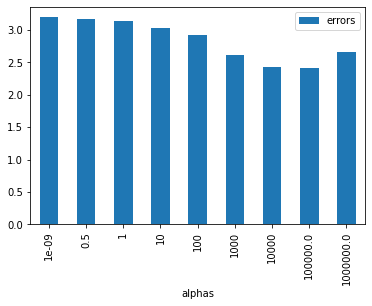

In [33]:
k_fold = KFold(n_splits=5, shuffle=True, random_state=10)

alphas = [1e-9, 0.5, 1, 10, 100, 1000, 10000, 1e5, 1e6]
errors = []
for a in alphas:
    scores = cross_val_score(Ridge(alpha=a), 
                X_train, y_train, cv=k_fold, 
                scoring = 'neg_mean_squared_error')
    errors.append(sqrt(mean(-scores) ) )
    
# We convert x-values to string because otherwise they would 
# be to far from each other
df_errors = pd.DataFrame({'alphas':[str(a) for a in alphas],
                        'errors':errors})
ax = df_errors.plot.bar(x='alphas')
df_errors

Let's analyze the best Ridge regression model.

In [35]:
model = Ridge(alpha=10000)
model.fit(X_train, y_train)
stats.summary(model, X_train, y_train)

Residuals:
    Min      1Q  Median      3Q     Max
-6.0995 -0.1336  0.4671  1.1175  3.6473


Coefficients:
            Estimate  Std. Error  t value   p value
_intercept  3.753547   10.199372   0.3680  0.715015
x1          0.001748    0.042402   0.0412  0.967343
x2          0.012230    0.001953   6.2609  0.000000
x3         -0.000110    0.002495  -0.0443  0.964938
x4         -0.000598    0.859005  -0.0007  0.999448
x5          0.000082    0.450277   0.0002  0.999857
---
R-squared:  0.44713,    Adjusted R-squared:  0.35795
F-statistic: 5.01 on 5 features


In [37]:
y_pred = model.predict(X_test)
sqrt(mean_squared_error(y_pred, y_test) )

2.5755139342125433

We improved just a bit.

May there be some non-linear dependency?

# Polynomial regression and regularization

Let's try a polynomial regression

In [38]:
def MyPolynomialRegression(degree=2, include_bias=False):
    return make_pipeline(PolynomialFeatures(degree, include_bias),
                LinearRegression() )


model = MyPolynomialRegression(degree=2)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
RMSE_quadr = sqrt(mean_squared_error(y_pred, y_test) )
print("RMSE quadr: ", RMSE_quadr, "RMSE linear: ", RMSE_lin)

RMSE quadr:  3.445892138439807 RMSE linear:  2.582661092110638


Clearly, **overfitting**.

Let's modify `MyPolynomialRegression` in order to make ridge regression instead of simple linear regression in the last step.

In [0]:
def MyPolynomialRegression(degree=2, include_bias=False, 
                           alpha=1e-9):
    return make_pipeline(PolynomialFeatures(degree, 
                                            include_bias),
                Ridge(alpha=alpha) )

,alphas,errors
0,0.5,7.042229
1,1,7.087750
2,10,6.736102
3,100,5.400845
4,1000,4.695892
5,100000.0,3.620537
6,1000000.0,3.399565
7,10000000.0,3.214597
8,1000000000.0,2.448453
9,1000000000000.0,2.891326


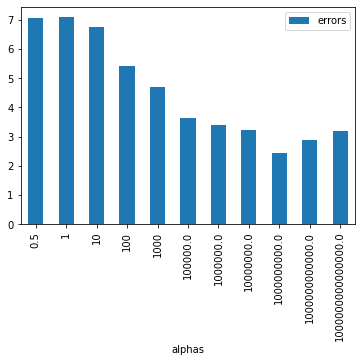

In [40]:
alphas = [0.5, 1, 10, 100, 1000, 1e5, 1e6, 1e7, 1e9, 1e12, 1e15]
errors = []
for a in alphas:
    scores = cross_val_score(MyPolynomialRegression(degree=2,
                    include_bias=False, alpha=a), 
                X_train, y_train, cv=k_fold, 
                scoring = 'neg_mean_squared_error')
    errors.append(sqrt(mean(-scores) ) )
    
df_errors = pd.DataFrame({'alphas':[str(a) for a in alphas],
                        'errors':errors})
ax = df_errors.plot.bar(x='alphas')
df_errors

Let's compute the test error for the best alpha

In [41]:
model = MyPolynomialRegression(degree=2, alpha=1e9)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
RMSE_poly_and_ridge = sqrt(mean_squared_error(y_pred, y_test) )
print("RMSE_poly_and_ridge: ", RMSE_poly_and_ridge,
      "RMSE linear: ", RMSE_lin)

RMSE_poly_and_ridge:  2.414737020723705 RMSE linear:  2.582661092110638


# Feature scaling

Go back to slides

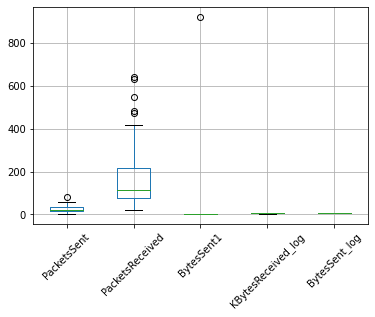

In [42]:
ax = df[features].boxplot()
ax.tick_params(axis='x', labelrotation=45)


The scale of the features is very diverse. Our regularized model is likely to ignore the "smallest" features.

In [0]:
# IGNORE THIS
if savefigures:
  from google.colab import drive
  mount_point = '/content/gdrive'
  drive.mount(mount_point, force_remount=True)
  drive_path = mount_point+'/My Drive/'
  my_path = drive_path + 'tsp/teaching/data-science-for-networks/img-from-code/02.regression/'

  plt.savefig(my_path+'c.boxplot.pdf')

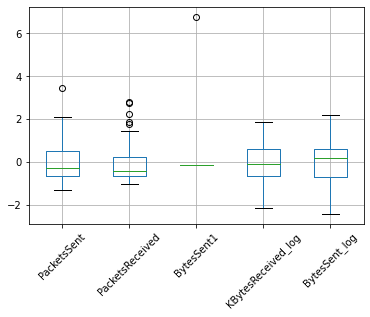

In [44]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
df_scaled = pd.DataFrame(X_scaled)
df_scaled.columns = features
ax = df_scaled.boxplot()
ax.tick_params(axis='x', labelrotation=45)

if savefigures:
  plt.savefig(my_path+'c.boxplot-scaled.pdf')

Scaling is usually included in the pipelines. Pipelines will follow the correct protocol when scaling. For instance, if we use a Max-Min Scaler, the pipeline defined in the following code will behave as follows:
* When you call `fit` on your pipeline (and you pass `X_train`,`y_train`), the pipeline will compute the Min and the Max of the features of `X_train`, scale `X_train`  accordingly and also storing these standard deviations for later use
* It will then train the model on the scaled dataset
* When you call `predict` on your pipeline (and you pass `X_test`), the pipeline will scale each sample based on the Min and the Max **computed before**
* The pipeline will make the prediction

Note the scaling parameters (e.g., the Min and the Max) are calculated only based on the training set.

Let's construct a pipeline with scaling and Ridge regression.

In [0]:
def MyScalingAndPolyRidge(degree=2, alpha=2):
    return make_pipeline(
       PolynomialFeatures(degree=degree, include_bias=False),
        MinMaxScaler(),
        Ridge(alpha=alpha)
    )

Let's find the best alpha with GridSearch

,alphas,errors
0,1e-09,5.326065
1,0.1,2.908537
2,0.2,2.864677
3,0.5,2.769501
4,1,2.697342
5,10,2.617988
6,100,2.981795
7,1000,3.157269
8,100000.0,3.182301
9,1000000.0,3.182535


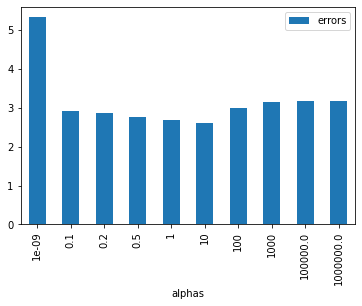

In [57]:
alphas = [1e-9, 0.1, 0.2, 0.5, 1, 10, 100, 1000, 1e5, 1e6]
errors = []
for a in alphas:
    scores = cross_val_score(MyScalingAndPolyRidge(degree=2,
                    alpha=a), 
                X_train, y_train, cv=k_fold, 
                scoring = 'neg_mean_squared_error')
    errors.append(sqrt(mean(-scores) ) )
    
df_errors = pd.DataFrame({'alphas':[str(a) for a in alphas],
                        'errors':errors})
ax = df_errors.plot.bar(x='alphas')
df_errors

After scaling, the best $\alpha$ is 10.

In [58]:
model = MyScalingAndPolyRidge(degree=2,
                    alpha=10)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
RMSE_scaling_and_poly_and_ridge = \
    sqrt(mean_squared_error(y_pred, y_test) )
    
print("RMSE_scaling_and_poly_and_ridge: ",
      RMSE_scaling_and_poly_and_ridge,
      ", RMSE_poly_and_ridge:", 
      RMSE_poly_and_ridge)

RMSE_scaling_and_poly_and_ridge:  2.3823292557205633 , RMSE_poly_and_ridge: 2.414737020723705


# Grid search

Let's find the best combination of polynomial degree and regularization weight.

Let's check how parameters are called

In [59]:
GridSearchCV(MyScalingAndPolyRidge(), []).get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__memory', 'estimator__steps', 'estimator__verbose', 'estimator__polynomialfeatures', 'estimator__minmaxscaler', 'estimator__ridge', 'estimator__polynomialfeatures__degree', 'estimator__polynomialfeatures__include_bias', 'estimator__polynomialfeatures__interaction_only', 'estimator__polynomialfeatures__order', 'estimator__minmaxscaler__copy', 'estimator__minmaxscaler__feature_range', 'estimator__ridge__alpha', 'estimator__ridge__copy_X', 'estimator__ridge__fit_intercept', 'estimator__ridge__max_iter', 'estimator__ridge__normalize', 'estimator__ridge__random_state', 'estimator__ridge__solver', 'estimator__ridge__tol', 'estimator', 'iid', 'n_jobs', 'param_grid', 'pre_dispatch', 'refit', 'return_train_score', 'scoring', 'verbose'])

In [0]:
parameters_to_test=[{'ridge__alpha':[0.1, 0.2, 0.5, 1, 5, 10, 50, 
                             1e6],
                     'polynomialfeatures__degree':np.arange(1,6)
                    }]
grid = GridSearchCV(MyScalingAndPolyRidge(), parameters_to_test,
                    cv=k_fold, scoring='neg_mean_squared_error'
    )

In [61]:
grid.fit(X_train, y_train)
print("The best parameters are", grid.best_params_)

The best parameters are {'polynomialfeatures__degree': 1, 'ridge__alpha': 1}


Let's validate on the test set

In [62]:
model = grid.best_estimator_
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
RMSE_grid = sqrt(mean_squared_error(y_pred, y_test))

RMSE_grid

2.4828317962263964

In [63]:
TODO

NameError: ignored

# Recursive Feature Elimination

In [0]:
def MyScaledLinearRegression():
    return make_pipeline(
        StandardScaler(),
        LinearRegression()
        )

The following code will lead to a **known error**

In [0]:
# The following code will lead to a known error

rfe = RFECV(MyScaledLinearRegression())
rfe.fit(X_train, y_train)

RuntimeError: ignored

We need to modify the `Pipeline` class (inspired by [this blog](https://ramhiser.com/post/2018-03-25-feature-selection-with-scikit-learn-pipeline/) and this [StackOverflow post](https://stackoverflow.com/q/36683230/2110769))

In [0]:
class MyPipeline(Pipeline):

    def fit(self, X, y=None, **fit_params):
        super(MyPipeline, self).fit(X, y, **fit_params)
        self.coef_ = self.steps[-1][-1].coef_
        return self

Let's try again

In [0]:
def MyScaledLinearRegression():
    return MyPipeline(
        [ 
            ('my_nice_scaler',StandardScaler() ), 
            ('my_beautiful_regression', LinearRegression() )
        ]
    )

rfe = RFECV(MyScaledLinearRegression(), cv=k_fold, 
            scoring='neg_mean_squared_error')
rfe.fit(X_train, y_train)

RFECV(cv=KFold(n_splits=5, random_state=10, shuffle=True),
      estimator=MyPipeline(memory=None,
                           steps=[('my_nice_scaler',
                                   StandardScaler(copy=True, with_mean=True,
                                                  with_std=True)),
                                  ('my_beautiful_regression',
                                   LinearRegression(copy_X=True,
                                                    fit_intercept=True,
                                                    n_jobs=None,
                                                    normalize=False))],
                           verbose=False),
      min_features_to_select=1, n_jobs=None, scoring='neg_mean_squared_error',
      step=1, verbose=0)

Let's check how the cross-validated error changed with the num of features

In [0]:
RMSE_values = np.sqrt(- rfe.grid_scores_)
RMSE_values

array([0.87379709, 0.55692171, 0.57596145, 0.57695686, 0.56897865,
       0.58660279, 0.5851578 , 0.58562005, 0.5868528 , 0.58999872,
       0.58996762])

[Text(0, 0.5, 'Cross-Val RMSE'), Text(0.5, 0, 'Num of features')]

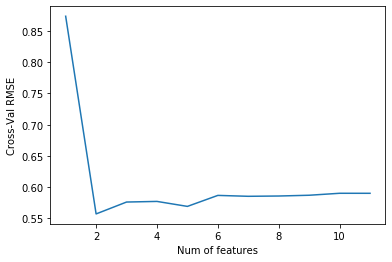

In [0]:
num_of_features = np.arange(1,len(features)+1)

fig, ax = plt.subplots()
ax.plot(num_of_features, RMSE_values)
ax.set(xlabel="Num of features", ylabel="Cross-Val RMSE")

Two features seem to give the best model. What are such features?

In [0]:
all_features_array = np.array(features)
selected_features = all_features_array[rfe.support_]
selected_features

array(['QoA_resolution', 'QoA_audio-rate'], dtype='<U15')

Let's test the selected model

In [0]:
y_pred = rfe.predict(X_test)
RMSE_feat_elimin = sqrt(mean_squared_error(y_pred, y_test))
print('RMSE_feat_elimin=', RMSE_feat_elimin, ', RMSE_grid', RMSE_grid,
     ', RMSE_lin', RMSE_lin)

RMSE_feat_elimin= 0.5491052022377344 , RMSE_grid 0.5201105216337418 , RMSE_lin 0.65021592316979


This model is better than the linear regression where we had all the features. However, the one we found with grid (best polynomial with ridge regularization) is still the best.

Some idea to improve even more the model?

<details>
<summary>...
    
__Click__
</summary>

* Find the best polynomial + normalization model based only on these two features. Or
* Use RFECV on the polynomial model to select a subset of transformed features. Or
* 
</details>